In [4]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

## GCA

In [260]:
from operator import itemgetter
import numpy as np

def enforce_bounds(params, LowerBound, UpperBound):
    new_params = []
    for i in np.arange(len(params)):
        currene_param = params[i]
        lb = LowerBound[i]
        ub = UpperBound[i]
        if currene_param<lb:
            currene_param = lb
        elif currene_param>ub:
            currene_param = ub
        new_params.append(currene_param)
    return new_params

def RandomParameters(PopulationSize,OrigialParameters,scale,LowerBound,UpperBound):
    #PopulationSize is the number of randomized sets of parameters this function generates.
    #OriginalParemeters will be a first educated guess and the rest of the
    #parameters will be generated around it.
    #scale is the relative value of the change, scale = 1 means  new parameters
    #will be roughly the same order of magnitude; scale = 0.1 means the new
    #parameters will be roughly 1/10th of the original ones.
    to_return = []
    i = 0
    while i<PopulationSize:
        temp = [(param+np.finfo(float).eps)*(1+scale*(2*np.random.uniform()-1)) for param in OrigialParameters]
        temp = enforce_bounds(temp, LowerBound, UpperBound)
        to_return.append(temp)
        
        i+=1
    return to_return

def GenerationFitness(FitFun,Generation):
    Gi_fit = []
    for i in np.arange(len(Generation)):
        Gi_fit.append(FitFun(Generation[i]))
        if np.isnan(Gi_fit[i]):
            Gi_fit[i] = numpy.NINF
    return Gi_fit

def crossover(Gi_mate_1,Gi_mate_2,CrossPoint):
    Offspring = []
    for parent1, parent2 in zip(Gi_mate_1,Gi_mate_2):
        parent1 = list(parent1)
        parent2 = list(parent2)
        off_1 = parent1[0:CrossPoint]+parent2[CrossPoint:]
        off_2 = parent2[0:CrossPoint]+parent1[CrossPoint:]
        Offspring.append(off_1)
        Offspring.append(off_2)
    return Offspring

def mutate(Offsprings,MutRate,MutMagnitude,Mutation_dampering,lb,ub):
    new_offsprings = []
    decaying_rate = 0.9
    
    # for each each offspring, chek if there will be a mutation on each gene
    for offspring in Offsprings:
        new_off = []
        for gene in offspring:
            if np.random.binomial(n=1,p=decaying_rate) == 1:
                new_gene = (gene+np.finfo(float).eps) * (1+ MutMagnitude*(2*np.random.uniform()-1)) * decaying_rate**Mutation_dampering
            else:
                new_gene = gene
            new_off.append(new_gene)
        new_offsprings.append(enforce_bounds(new_off,lb,ub))
    return new_offsprings


def genetic_algorithm(FitFun, initial_guess, lower_bound, upper_bound, options=None):
    #Custom Genetic Algorithm. Developed by Edwin Juarez on 2016-03-21, ported to python on 2019-03-12

    #Initialize the parameters
    parameters = initial_guess
    chromosome_length = len(parameters)
    fitness = np.NINF

    # fprintf('The initial guess is:');
    # parameters
    fitness = FitFun(initial_guess)

    # Choose parameters:
    
    ## Population Size, N : Depends on the dimensions of the sample space
    PopSize = 1e2

    ## Number of mating individuals must be an even number
    FittestNumber = int(min(PopSize*0.1,10**3*0.05)) # 10 percent of the population will reproduce up to 50 individuals

    ## Number of "Elite" individuals who will remain from Gen[i] to Gen[i+1]
    Elite = int(min(PopSize*0.1,10**3*0.05)) # 10 percent of the population up to 50 individuals

    ## Number of Generations to Simulate: How many iterations to simulate? Presumably the more the better.
    LastGen = 50

    ## Mutation Rates: Probability of each gene (parameter) having a point mutation.
    MutRate = 0.98 # there is a 98 percent chance of a mutation. There is a lot of genetic variation!
    MutMagnitude = 2 # with a mutation the parameter will change up to 100%

    # Crossover Points: Location(s) where the individuals swap genes in producing children (next generation).
    # CrossPoint = 1; # swap (after) the first "chromosome" [parameter]
    CrossPoint = int(np.floor(1+chromosome_length*np.random.uniform())) # Discrete Uniform RV ranging from 1 to chromosome_length (the number of parameters)
    
    # Initialize the G[0] population randomly: Create a set of N solutions randomly
    # Gi = RandomParameters(PopSize,parameters);
    Gi = RandomParameters(PopSize,parameters,1,lower_bound,upper_bound);
#     vanguardia=Gi(1:4,:);
#     prev_vanguardia = Gi(1,:);
    # Running the main loop now
    i=0
    print('Runing the custom genetic algorithm')
#     print("The first generation takes the longest")
    while i<LastGen:
#         print(f"Generation {i}")
        # Calculate fitness for population
        Gi_fit = GenerationFitness(FitFun,Gi)

        ## Select mates to create children for the G1 (N+1) population
        ## Mate selection: Individuals ranked proportional to their fitness

        ###Order them from the most fit to the least fit
        temp = []
        for params, fitness in zip(Gi, Gi_fit):
            temp2 = params.copy()
            temp2.append(fitness)
            temp.append(temp2)
        temp = sorted(temp, key=itemgetter(len(temp[0])-1), reverse=True)
        ###Consider only the fittest individuals
        Gi_fittest = temp[0:FittestNumber]
        # Drop the fitness
        for x in Gi_fittest:
            del x[len(x)-1]

        ###Randomly assign mates
        Gi_mate = np.random.permutation(Gi_fittest) # permutate all individuals
        Gi_mate_1 = Gi_mate[0:int(FittestNumber/2)] # split the population in two
        Gi_mate_2 = Gi_mate[int(FittestNumber/2):]

        ### Mate: Genes are exchanged prescribed by cross-over points
        Offsprings = crossover(Gi_mate_1,Gi_mate_2,CrossPoint)

        ### Introduce point mutations: 
        Offsprings = mutate(Offsprings,MutRate,MutMagnitude,i,lower_bound,upper_bound)

        ### Clone the Elite members and mutate the clones
        Clones = mutate(Gi_fittest[0:Elite],MutRate,MutMagnitude,1,lower_bound,upper_bound)

        ### "Elite" fittest individuals mate with the next generation,
        ### a mutated clone of some them also carries on.

        ### on each generation a number of random individuals show up equal to the
        ### number of Elite individuals
        Gi = Gi_fittest[0:Elite]+Clones+Offsprings+RandomParameters(Elite,parameters,1,lower_bound,upper_bound)
        i += 1
    print(f'Done!, fittest individual was {Gi_fittest[0]} with fitness {FitFun(Gi_fittest[0])}')
    return Gi_fittest[0]

##  Create Cells Mask

Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.
A value of 0 means it deos not belong the mask and it is rendered as black.


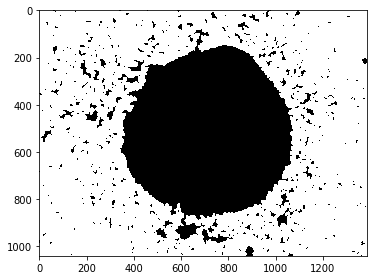

In [284]:
# Mostly from here: https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
%matplotlib inline
import cv2
import numpy as np
from skimage import draw
from skimage import io

 
# Read image
im_in = cv2.imread("analyses/MDA231_stopper_1_c3.tif", cv2.IMREAD_GRAYSCALE);
 
# Threshold.
# Set values equal to or above 20 to 0.
# Set values below 20 to 255.
 
th, im_th = cv2.threshold(im_in, 20, 255, cv2.THRESH_BINARY_INV);
 
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
io.imsave(fname='temp_output.png', arr=im_out)

# im_out_inv = cv2.bitwise_not(im_out)


# dilate the mask:
k_size = 4
k_half = k_size/2
kernel = np.ones((k_size,k_size),np.uint8)
coords = draw.circle(k_half, k_half, k_half, shape=im_th.shape)
kernel[coords] = 1 
erosion = cv2.erode(im_out,kernel,iterations = 1)
dilation = cv2.dilate(cv2.bitwise_not(erosion),kernel,iterations = 1)
# cells_mask = cv2.bitwise_not(dilation)
cells_mask = dilation/255


io.imshow(cells_mask)
print("Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.")
print("A value of 0 means it deos not belong the mask and it is rendered as black.")
# io.imsave(fname='mask.png', arr=dilation)

## cost functions

### Attempt 0

In [13]:
import matplotlib.pyplot as plt
filename = 'analyses/MDA231_stopper_1_c3.tif'


In [14]:
image = io.imread(filename,as_grey=True)
im2 = image>0.2
im2 = im2.astype(int)

x_opt = 691.25591905
y_opt = 529.27572426

/opt/conda/envs/python3.6/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


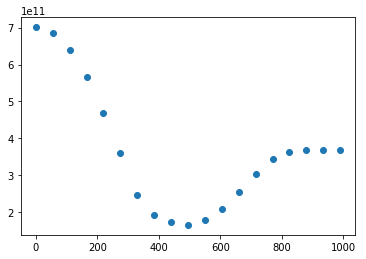

In [19]:
def cost(params):
    image = im2
    x0= params[0]
    y0 = params[1]
    r = params[2]
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1 
    penalty = 1
#     score = np.sum(template) - penalty*(len(template)- np.sum(template))
#     print('%g\t\t%g' % (2*np.pi*r*r, np.sum(template == image)**2))
    score = 2*np.pi*r*r - penalty*(np.sum(template == image)**2 - 2*np.pi*r*r)  
    return -score


import matplotlib.pyplot as plt
x = [i for i in np.arange(0,1000,55)]
y = [cost([x_opt,y_opt,i]) for i in x]
plt.scatter(x,y)

### optimize

In [262]:
from skimage import io, color, measure, draw, img_as_bool
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [263]:
filename = 'analyses/MDA231_stopper_1_c3.tif'
image = io.imread(filename,as_grey=True)
im2 = image>0.2
im2 = im2.astype(int)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [264]:
maxy, maxx = image.shape
minx, miny = (0,0)
maxr = min(maxx,maxy)/2

In [265]:
x0 = im2.shape[1]/2
y0 = im2.shape[0]/2
r0 = im2.shape[1]/3

In [266]:
image = im2.copy()


In [2]:
@genepattern.build_ui
# def cost(params):
#     # normalize axis:
#     image = im2.copy()
#     maxy, maxx = image.shape
#     maxr = min(maxx,maxy)/2
    
    
#     x0= params[0]
#     y0 = params[1]
#     r0 = params[2]
    
#     xnorm = x0/maxx
#     ynorm = y0/maxy
#     rnorm = r0/maxr
    
#     coords = draw.circle(y0, x0, r0, shape=image.shape)
#     template = np.zeros_like(image) #set all values to be zero
#     template[coords] = 1
    
#     penalty = 1 #(maxy+maxx)/2
#     # values outside of the box should be penalized too
#     if (x0+r0>maxx) or (y0+r0>maxy) or (x0-r0 <0) or (y0-r0 <0):
#         return penalty*2*np.pi*rnorm*rnorm
    
#     score = 2*np.pi*rnorm*rnorm - penalty*(np.sum(template == image)/np.sum(image) - 2*np.pi*rnorm*rnorm)
#     return -score
def cost(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params[0]
    y0 = params[1]
    r0 = params[2]
    
#     xnorm = x0/maxx
#     ynorm = y0/maxy
#     rnorm = r0/maxr
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
#     penalty = np.sum(template == 1)/area
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
#     score = 2*np.pi*r0*r0 - penalty*(np.sum(template == image) - 2*np.pi*r0*r0)
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return -score

UIBuilder(function_import='cost', name='cost', params=[{'name': 'params', 'label': 'params', 'optional': False…

      fun: -0.5042590704370586
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        , -0.00304046])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 220
      nit: 3
   status: 2
  success: False
        x: array([694.       , 520.       , 349.2620596])
############
starting: [694.0, 520.0, 347.0]
optimal: [694.0, 520.0, 349.2620596010312]
############
############
Method "Defatult""	objective=-0.5042590267438614
############


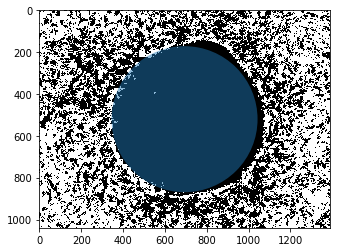

CPU times: user 4.23 s, sys: 112 ms, total: 4.34 s
Wall time: 4.21 s


In [229]:
%%time
method = 'Defatult'
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0/2], bounds=bnds,options={'maxiter': 1e10, 'disp': True})
print(res)

x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]

print('############')
print('starting:',[x0, y0,r0])
print('optimal:',[x_opt,y_opt,r_opt])
print('############')
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

[694.0, 520.0, 300]
############
Method "SLSQP""	objective=-0.39118729054406093
############


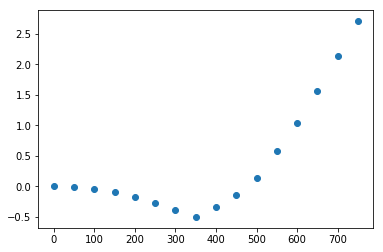

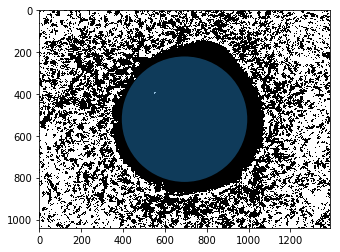

In [245]:
def cost(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params[0]
    y0 = params[1]
    r0 = params[2]
    
#     xnorm = x0/maxx
#     ynorm = y0/maxy
#     rnorm = r0/maxr
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
#     penalty = np.sum(template == 1)/area
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
#     score = 2*np.pi*r0*r0 - penalty*(np.sum(template == image) - 2*np.pi*r0*r0)
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return -score

import matplotlib.pyplot as plt
x = [i for i in np.arange(0,800,50)]
y = [cost([x0,y0,i]) for i in x]
plt.scatter(x,y)

x_opt = x0
y_opt = y0
r_opt = 300
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

[694.0, 520.0, 462]
############
Method "TNC""	objective=-0.0895576124374029
############


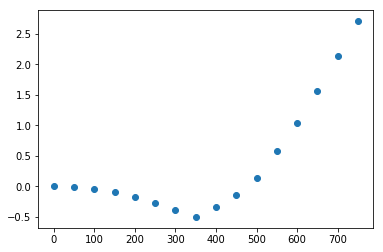

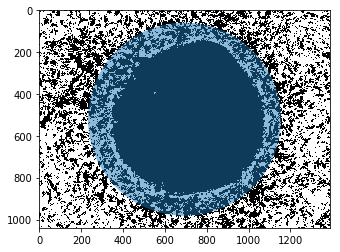

In [293]:
def cost(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params[0]
    y0 = params[1]
    r0 = params[2]
    
#     xnorm = x0/maxx
#     ynorm = y0/maxy
#     rnorm = r0/maxr
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
#     penalty = np.sum(template == 1)/area
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
#     score = 2*np.pi*r0*r0 - penalty*(np.sum(template == image) - 2*np.pi*r0*r0)
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return -score

import matplotlib.pyplot as plt
x = [i for i in np.arange(0,800,50)]
y = [cost([x0,y0,i]) for i in x]
plt.scatter(x,y)

x_opt = x0
y_opt = y0
r_opt = 462
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

[694.0, 520.0, 525]
############
Method "SLSQP""	objective=0.3407981885624969
############


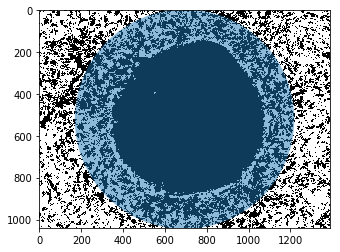

CPU times: user 222 ms, sys: 120 ms, total: 342 ms
Wall time: 214 ms


In [246]:
%%time
x_opt = x0
y_opt = y0
r_opt = 525
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

      fun: -0.5027793576468831
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.       ,   0.       , 692.7480322])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([694., 520., 347.])
[694.0, 520.0, 347.0]
############
Method "L-BFGS-B""	objective=-0.5027793585486774
############


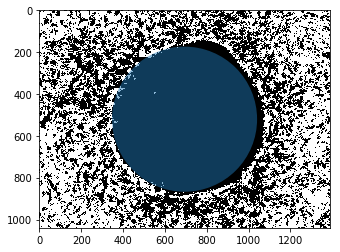

CPU times: user 1.72 s, sys: 112 ms, total: 1.84 s
Wall time: 1.71 s


In [248]:
%%time
method = 'L-BFGS-B'
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
print(res)
x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

      fun: -0.5027793576468831
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.       ,   0.       , 692.7480322])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([694., 520., 347.])
[694.0, 520.0, 347.0]
############
Method "L-BFGS-B""	objective=-0.5027793585486774
############


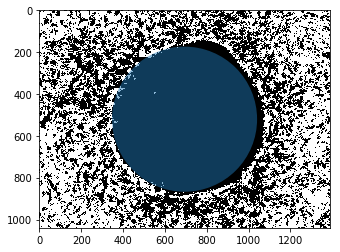

CPU times: user 1.71 s, sys: 105 ms, total: 1.82 s
Wall time: 1.69 s


In [249]:
%%time
method = 'L-BFGS-B'
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
print(res)

x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

     fun: -0.08628905331939019
     jac: array([3463.75526491, 4156.50631789, 9005.75966071])
 message: 'Linear search failed'
    nfev: 67
     nit: 1
  status: 4
 success: False
       x: array([694.        , 520.        , 462.70941205])
[694.0, 520.0, 462.7094120470099]
############
Method "TNC""	objective=-0.08628905331939019
############


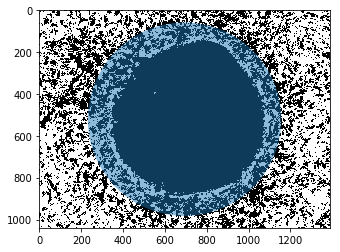

CPU times: user 8.56 s, sys: 4.42 s, total: 13 s
Wall time: 12.9 s


In [292]:
%%time
method = 'TNC'
bnds = ((0, maxx), (0, maxy), (0,maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
print(res)

x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

     fun: -0.5027793585486774
     jac: array([  0.       ,   0.       , 692.7480322])
 message: 'Linear search failed'
    nfev: 29
     nit: 0
  status: 4
 success: False
       x: array([694., 520., 347.])
[694.0, 520.0, 347.0]
############
Method "TNC""	objective=-0.5027793585486774
############


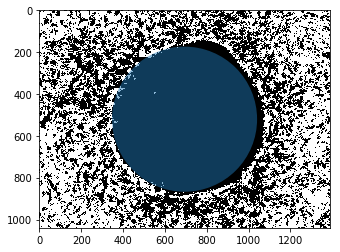

CPU times: user 3.01 s, sys: 120 ms, total: 3.13 s
Wall time: 3.01 s


In [250]:
%%time
method = 'TNC'
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
print(res)

x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

      fun: -0.08626576742423886
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        , -0.00402774])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 216
      nit: 3
   status: 2
  success: False
        x: array([694.        , 520.        , 462.67266706])
############
starting: [694.0, 520.0, 462.6666666666667]
optimal: [694.0, 520.0, 462.6726670561262]
############
############
Method "L-BFGS-B""	objective=-0.08629345358363472
############


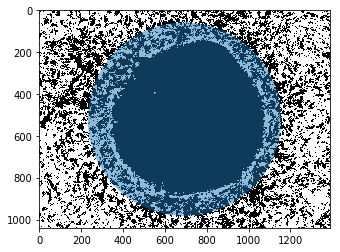

CPU times: user 6.18 s, sys: 116 ms, total: 6.3 s
Wall time: 6.17 s


In [287]:
%%time
method = 'SLSQP'
bnds = ((0, maxx), (0, maxy), (0,2*maxr))
res = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
print(res)

x_opt = res.x[0]
y_opt = res.x[1]
r_opt = res.x[2]
print('############')
print('starting:',[x0, y0,r0])
print('optimal:',[x_opt,y_opt,r_opt])
print('############')
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

In [268]:
init_params = [x0, y0,r0]
init_params

[694.0, 520.0, 462.6666666666667]

    mutate(init_params

[694.0, 520.0, 519.9998877262684]


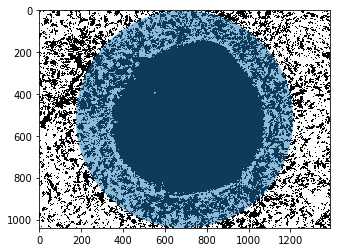

[694.0, 520.0, 519.9998877262684]


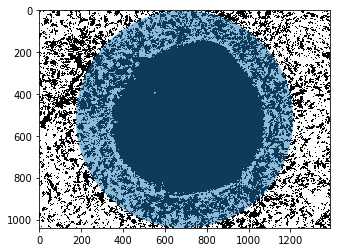

[694.0, 520.0, 519.9998877262684]


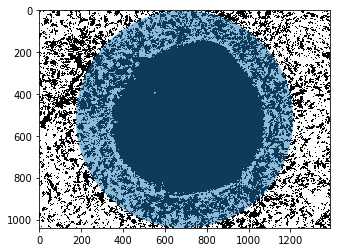

[694.0, 520.0, 519.9998877262684]


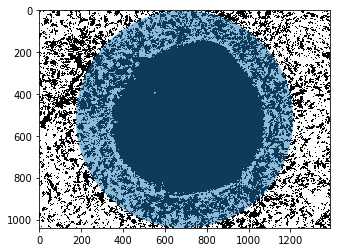

[694.0, 520.0, 519.9998877262684]


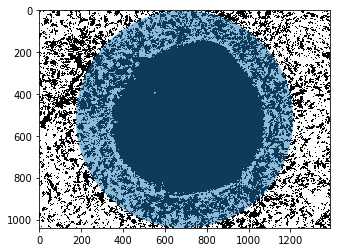

[694.0, 520.0, 519.9998877262684]


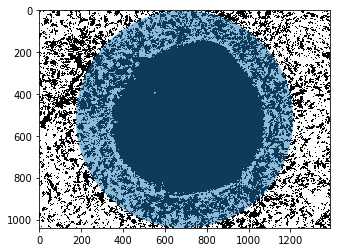

[694.0, 520.0, 519.9998877262684]


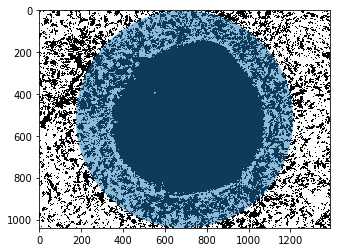

[694.0, 520.0, 519.9998877262684]


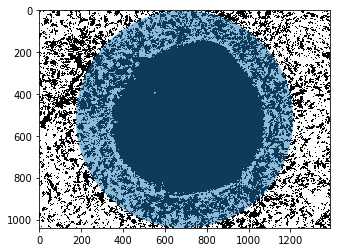

[694.0, 520.0, 519.9998877262684]


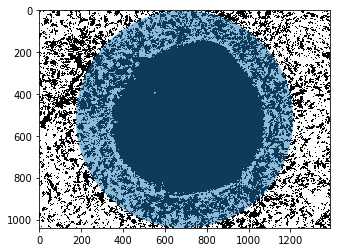

KeyboardInterrupt: 

In [280]:
res = []
for i in np.arange(10):
    mutate([init_params],MutRate=0.98,MutMagnitude=2,Mutation_dampering=i,lb=[0,0,0],ub=[maxx,maxy,2*maxx])
    temp = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
    res.append(temp)
    x_opt = temp.x[0]
    y_opt = temp.x[1]
    r_opt = temp.x[2]
    print([x_opt,y_opt,r_opt])
    f, ax = plt.subplots()
    circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
    ax.imshow(im2, cmap='gray', interpolation='nearest')
    ax.add_artist(circle)
    plt.show()

In [278]:
def meta_optimize(cost,init_params, bounds, method = 'SLSQP'):
    res = []
    for i in np.arange(10):
        mutate([init_params],MutRate=0.98,MutMagnitude=2,Mutation_dampering=i,lb=[0,0,0],ub=[maxx,maxy,2*maxx])
        temp = optimize.minimize(cost, x0=[x0, y0,r0], bounds=bnds, method=method)
        res.append(temp)
        x_opt = temp.x[0]
        y_opt = temp.x[1]
        r_opt = temp.x[2]
        print([x_opt,y_opt,r_opt])
        f, ax = plt.subplots()
        circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
        ax.imshow(im2, cmap='gray', interpolation='nearest')
        ax.add_artist(circle)
        plt.show()

SyntaxError: invalid syntax (<ipython-input-278-40a73184867f>, line 1)

In [16]:
# genetic_algorithm(FitFun, initial_guess, lower_bound, upper_bound, options=None)

In [54]:
# bnds = ((0, maxx), (0, maxy), (0,2*maxr))
# res = optimize.minimize(cost, x0=[x0, y0,x0/2], bounds=bnds)
ret = genetic_algorithm(cost, initial_guess=[x0, y0,x0/2], lower_bound=[0,0,0], upper_bound=[maxx,maxy,2*maxx])
ret

Runing the custom genetic algorithm
Done!, fittest individual was [742.523913167467, 483.4473397861852, 476.9085505996856] with fitness -1.6798215109094934e+16


[742.523913167467, 483.4473397861852, 476.9085505996856]

In [55]:
opt_params = ret
opt_params

[742.523913167467, 483.4473397861852, 476.9085505996856]

[742.523913167467, 483.4473397861852, 476.9085505996856]


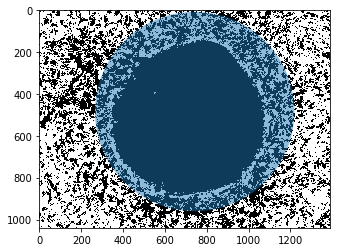

In [56]:
# x_opt = ret[0]
# y_opt = ret[1]
# r_opt = ret[2]
# print([x_opt,y_opt,r_opt])
# f, ax = plt.subplots()
# circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
# ax.imshow(im2, cmap='gray', interpolation='nearest')
# ax.add_artist(circle)
# plt.show()

In [57]:
# def cost2(params):
#     image = im2
#     x0= params[0]
#     y0 = params[1]
#     r = params[2]
#     coords = draw.circle(y0, x0, r, shape=image.shape)
#     template = np.zeros_like(image) #set all values to be zero
#     template[coords] = 1 
    
#     # values outside of the box should be penalized too
#     if (x0+r >maxx) or (y0+r>maxy) or (x0-r <0) or (y0-r <0):
#         return -1e20
    
#     penalty = 100000
#     score = 2*np.pi*r*r - penalty*(np.sum(template == image)**2 - 2*np.pi*r*r)  
#     return score

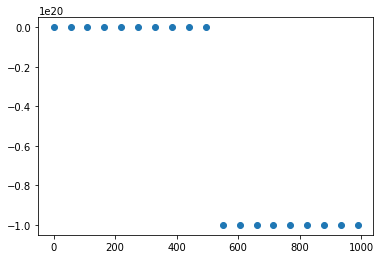

In [58]:
import matplotlib.pyplot as plt
x = [i for i in np.arange(0,1000,55)]
y = [cost([x0,y0,i]) for i in x]
plt.scatter(x,y)

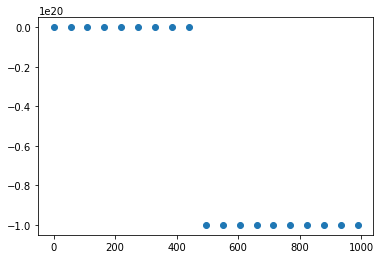

In [59]:
import matplotlib.pyplot as plt
x = [i for i in np.arange(0,1000,55)]
y = [cost([x_opt,y_opt,i]) for i in x]
plt.scatter(x,y)

In [235]:
def cost2(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params[0]
    y0 = params[1]
    r0 = params[2]
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return score

[13, 0, 2776]
############
Method "Defatult""	objective=-216.80830362222326
############


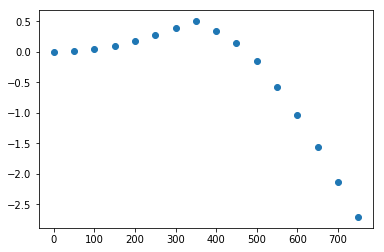

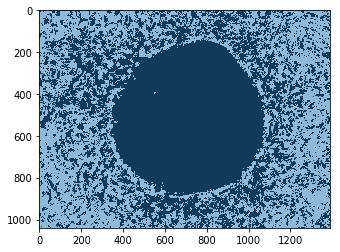

In [236]:
x = [i for i in np.arange(0,800,50)]
y = [cost2([x0,y0,i]) for i in x]
plt.scatter(x,y)

x_opt = 13
y_opt = 0
r_opt = 2776
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost2([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

In [239]:
ret = genetic_algorithm(cost2, initial_guess=[x0, y0,x0/2], lower_bound=[0,0,0], upper_bound=[maxx,maxy,2*maxx])
ret

Runing the custom genetic algorithm
Done!, fittest individual was [765.6640226016174, 547.9618753427742, 313.8985121269075] with fitness 0.4172415680525026


[765.6640226016174, 547.9618753427742, 313.8985121269075]

[765.6640226016174, 547.9618753427742, 313.8985121269075]


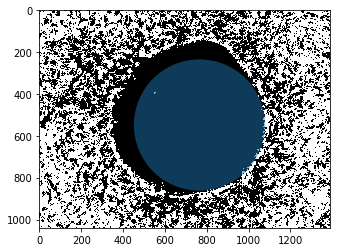

In [240]:
# opt_params = ret
# opt_params
x_opt = ret[0]
y_opt = ret[1]
r_opt = ret[2]
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()